# COGS 108 - Final Project 

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that PIDs will be scraped from the public submission, but student names will be included.)

* [  ] YES - make available
* [ x ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Yang Li
- Yiou Lyu
- Linfeng Hu
- Ruby Celeste Marroquin 

# Group Members IDs

- A15560579
- A15930345
- A15473121
- A16094382

# Research Question

How does the regional economic status of each province in mainland China correlate to its breakout and recovery of COVID-19?

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

(Copy this information for each dataset)
- Dataset Name: 
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [1]:
import pandas as pd
import json
import codecs
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

import os
import patsy
import scipy.stats as stats
import statsmodels.api as sm

import bs4
from bs4 import BeautifulSoup


# Data Cleaning

To clean our data, our general approach is to represent datasets in pandas dataframe. Then we drop irrelevant information or outliers in data. We also rename the columns to make it easier for later analyses.

Firstly, we deal with the datasets that consist of economic status data. 

This is the income per capita value for each province in mainland China. Income is measured in yuan. 

In [2]:
Income = pd.read_csv('Data/Income.csv')
Income = Income.dropna(axis=1, how='all')
#Income.head()

This is the per capita Gross Regional Product value for each province. GRP per capita is measured in yuan.

In [3]:
GRP = pd.read_csv('Data/GRP.csv')
GRP = GRP.dropna(axis=1, how='all')
#GRP.head()

Next, we move on to clean the population density related datasets.

Population per province here is calculated in the unit of 10000 persons). It includes all residents (permanent and temporary, rural and urban)at the end of that year.

In [4]:
population = pd.read_csv('Data/Population.csv')
population = population.dropna(axis = 1, how = 'all')
#population.head()

To calculate population density of a region, we also need to areas of each province. Here, area of each province is measured in unit of square kilometers.

Since we only need the area information of each separate region, we will drop the "Toal" row at the end which contains information about the total area of China(judging by the data contained, the row name should be a typo). We will also drop the proportion row because we only need the area number. 

In [5]:
area = pd.read_csv('Data/Area.csv')
area = area.dropna(axis = 1, how = 'all')
#shorten column names to make following analysis simpler
area = area.rename(columns={"Area (sq.km)": "Area"})
area = area[area.District != 'Toal']
area = area[area.columns[:2]]
area = area.rename(columns = {'District':'Region'})
area.head()

,Region,Area
0,Shanghai,8359
1,Tianjin,"11,917"
2,Beijing,"16,406"
3,Hainan,"35,177"
4,Ningxia,"51,893"


we also need to remove "," in the string in order to change it to type int.

In [6]:
def remove_comma(strin):
    strin = strin.replace(',','')
    return strin

area['Area']= area['Area'].apply(remove_comma)
area.head()

,Region,Area
0,Shanghai,8359
1,Tianjin,11917
2,Beijing,16406
3,Hainan,35177
4,Ningxia,51893


## Read Virus Data

In [7]:
# read virus data into dataframes 
list_of_virus_data = list()

# append data between Feb 1 and Feb 25 to list
for i in range(20200201,20200226): 
    path = './Data/virus/' + str(i) + '.csv'
    df = pd.read_csv(path)
    list_of_virus_data.append(df)
    
# File 20200226.csv is missing, reason unknow. 

    
# append data between Feb 27 and Feb 29 to list
for i in range(20200227,20200230): 
    path = './Data/virus/' + str(i) + '.csv'
    df = pd.read_csv(path)
    list_of_virus_data.append(df)

# append data between Mar 1 and  Mar 1 to list
for i in range(20200301,20200302): 
    path = './Data/virus/' + str(i) + '.csv'
    list_of_virus_data.append(pd.read_csv(path))
# access ith elment in the list using list_of_virus_data[i]
# for example list_of_virus_data[0] gives the first dataframe

## Cleaning Virus Data

### Defind functions that will be used when cleaning virus daeta

In [8]:
# remove spaces from string
def remove_space(string):
    try:
        return string.replace(" ","")
    except:
        return np.nan
    
# Find the maximum numerical number in a row
def find_max_in_a_row(df,row_index):
    num_cols = df.shape[1]
    max = 0
    for i in range(0,num_cols):
        value_in_ith_col = df.iloc[row_index,i]
        try:
            value_in_ith_col = remove_space(value_in_ith_col)
            if (int(value_in_ith_col) > max):
                max = int(value_in_ith_col)
        except:
            pass
    return max

# Find the maximum numerical numbers in each row of the dataframe, save them into df['max']
def find_max_in_a_dataframe(df):
    df['max'] = np.nan
    for i in range(0,df.shape[0]):
        df.loc[i,'max'] = find_max_in_a_row(df,i)
        
# Find the string in the data frame
# Return row_index,col_index of the string if the string is found
def find_string(df,string_to_find):
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    for row_index in range(0,num_rows):
        for col_index in range(0,num_cols):
            if (df.iloc[row_index,col_index] == string_to_find):
                return row_index,col_index
    raise Exception("string_to_find not found") 
    return


# Find "Hubei" in df
# Return row_index,col_index of "Hubei" if "Hubei" is found
def find_Hubei(df):
    return find_string(df,"Hubei")

def drop_population_column(df):
    
# drop column that contains '(10,000s)'
    try:
        target_string_3 = '(10,000s)'
        target_string_3_col_index = find_string(df,target_string_3)[1]
        df = df.drop(df.columns[target_string_3_col_index],axis=1)
    except:
        pass
# drop column that contains "Population (in 10,000s)"    
    try:
        target_string_1 = "Population (in 10,000s)"
        target_string_1_col_index = find_string(df,target_string_1)[1]
        df = df.drop(df.columns[target_string_1_col_index],axis=1)
    except:
        pass
# drop column that contains "Population"
    try:
        target_string_2 = "Population"
        target_string_2_col_index = find_string(df,target_string_2)[1]
        df =df.drop(df.columns[target_string_2_col_index],axis=1)
    except:
        return df
    
# index of "Province/Region/City" = col_index of Hubei
# "Confirmed Cases" = max value in every row


def clean_df_first_pass(df):
    # find column index of "Province/Region/City"
    city_col_index = find_Hubei(df)[1]
    df["Province/Region/City"] = df.iloc[:,city_col_index]
    find_max_in_a_dataframe(df)
    # Drop all rows above Hubei
    for i in range(0, find_Hubei(df)[0]):
        df = df.drop(i)
    # Find out df["Confirmed Cases"]
    df["Confirmed Cases"] = df['max']
    df = df[["Province/Region/City","Confirmed Cases"]]
    return df



def drop_rows_whose_city_length_too_long(df,max_length):
    num_rows = df.shape[0]
    for i in range(0,num_rows):
        try:
            city = df.loc[i,'Province/Region/City']
            city_length = len(city)
            if city_length > max_length:
                df = df.drop(i)
        except:
            if not(np.isnan(city)):
                raise Exception("fail to drop the " + str(i) + "th row, which is too long")
    return df

def get_city_cases(df,region_name):
    num_rows = df.shape[0]
    return (df[df["Province/Region/City"] == region_name]["Confirmed Cases"]).iloc[0]



def merge_one_day(day):
    day_name = "Day " + str(day)
    df[day_name] = np.nan
    for i in range(0,df.shape[0]):
        #print(i)
        try:
            region_name = df.loc[i,"Province/Region/City"]
            num_cases = get_city_cases(list_of_virus_data[day],region_name)
            df.loc[i,day_name] = num_cases
        except:
            df.loc[i,day_name] = np.nan

## Get population of each province/area from WHO Report

In [9]:
list_of_virus_data[-1].head()

,F1,F3,F4,F5,F6,F7,F8,Number of Records,Population
0,Region/,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
1,NaN,Confirmed,Suspecte,d,NaN,Confirmed,NaN,1,"(10,000s)"
2,City,cases,cases,NaN,Deaths,NaN,Deaths,1,NaN
3,NaN,NaN,NaN,NaN,NaN,cases,NaN,1,NaN
4,Hubei,570,NaN,64,34,66907,2761,1,5917


In [10]:
# Get population of each province/area from WHO Report
population_from_WHO_report = list_of_virus_data[-1]
population_from_WHO_report = population_from_WHO_report[['F1',"Population"]]

# Clean population data
population_from_WHO_report.columns = ["Province/Region/City","Population" ]
population_from_WHO_report = population_from_WHO_report.drop(0)
population_from_WHO_report = population_from_WHO_report.drop(1)
population_from_WHO_report = population_from_WHO_report.drop(2)
population_from_WHO_report = population_from_WHO_report.drop(3)
population_from_WHO_report =population_from_WHO_report.reset_index(drop=True)

# Multiply populatino by 10000 for each province/region, since the unit is 10000
population_from_WHO_report = population_from_WHO_report.astype({'Population': 'int'})
population_from_WHO_report["Population"] = population_from_WHO_report["Population"] * 10000

### Drop population column from all virus dataframes

In [11]:
for i in range (0,len(list_of_virus_data)):
    try:
        list_of_virus_data[i] = drop_population_column(list_of_virus_data[i])
    except:
        pass

### Clean df: First Pass

In [12]:
for i in range(0,len(list_of_virus_data)):
    try:
        list_of_virus_data[i] = clean_df_first_pass(list_of_virus_data[i])
    except:
        print(i)

### Gather all the province/area names from all dfs

In [13]:
# get all the province names
df = list_of_virus_data[0]
for i in range (1,len(list_of_virus_data)):
    df = df.merge(list_of_virus_data[i],on="Province/Region/City",how='outer')
df = df[["Province/Region/City"]]

### Drop rows whose city name is too long or too short (because these rows are not data for cities)

In [14]:

# Drop rows whose city names are too long
df = drop_rows_whose_city_length_too_long(df,25)


### Merge all the dfs in list_of_virus_data into one df. Rows are province/area names, columns are the number of confirmed cases every day of the province/area names

In [15]:
# merge all confirmed cases into df
for i in range(0,len(list_of_virus_data)):
    merge_one_day(i)

In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Fill nan in df with 0

In [17]:
# Fill nan in df with 0
df = df.fillna(0)

In [18]:
# add one column in df, storing the ith day's day of each province
# df.insert(loc=len(df.columns),column="day 0",value=np.nan)
#df["day0"] = np.nan
#for i in range(0,df.shape[0]):
#    region_name = df.loc[i,"Province/Region/City"]
#    try:
#        num_cases = get_city_cases(list_of_virus_data[0],region_name)
#        df.loc[i,'day0'] = num_cases
#    except:
#        df.loc[i,'day0'] = np.nan

### Drop rows whose province/city/regison is 0 (nan)

In [19]:
for i in range(0,df.shape[0]):
    if (df.loc[i,'Province/Region/City'] == 0):
        df = df.drop(i)       

### Drop "Total". It is irrelvant to our further analysis. 
### Drop "Shanxi". Because there are two provinces names "shanxi" in China. Their names are distinct in Chinese, but ambiguous in English. Thus, drop "shanxi" to reduce ambiguity. 
### Drop 'MacaoSar' and 'MacaoSAR' since there's no confirmed case at all

In [20]:
# Drop "Total". It is irrelvant to our further analysis
df = df.drop(df[df['Province/Region/City'] == "Total"].index[0])
df = df.drop(df[df['Province/Region/City'] == "Totals"].index[0])

# Drop "shanxi", because there are two provinces names "shanxi" in China. 
# Their names are distinct in Chinese, but ambiguous in English. 
# Thus, drop "shanxi" to reduce ambiguity. 
df = df.drop(df[df['Province/Region/City'] == "Shanxi"].index[0])

# Drop 'MacaoSar' & 'MacaoSAR' since there's never a COVID-19 patient appear
df = df.drop(df[df['Province/Region/City'] == "MacaoSar"].index[0])
df = df.drop(df[df['Province/Region/City'] == "MacaoSAR"].index[0])

In [21]:
# Reset df index
df = df.reset_index(drop = True)
df

,Province/Region/City,Day 0,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28
0,Hubei,7153.0,9074.0,11177.0,13522.0,16678.0,19665.0,22112.0,24953.0,27100.0,29631.0,31728.0,33366.0,34874.0,51986.0,54406.0,56249.0,58182.0,59989.0,61682.0,62031.0,62662.0,63454.0,64084.0,64287.0,64786.0,65596.0,65914.0,66337.0,66907.0
1,Zhejiang,599.0,661.0,724.0,829.0,895.0,954.0,1006.0,1048.0,1075.0,1104.0,1117.0,1131.0,1145.0,1155.0,1162.0,1167.0,1171.0,1172.0,1173.0,1175.0,1203.0,1205.0,1205.0,1205.0,1205.0,1205.0,1205.0,1205.0,1205.0
2,Guangdong,520.0,604.0,683.0,797.0,870.0,944.0,1018.0,1075.0,1120.0,1151.0,1177.0,1219.0,1241.0,1261.0,1294.0,1316.0,1322.0,1328.0,1331.0,1332.0,1333.0,1339.0,1342.0,1345.0,1347.0,1347.0,1348.0,1349.0,1349.0
3,Henan,422.0,493.0,566.0,675.0,764.0,851.0,914.0,981.0,1033.0,1073.0,1105.0,1135.0,1169.0,1184.0,1212.0,1231.0,1246.0,1257.0,1262.0,1265.0,1267.0,1270.0,1271.0,1271.0,1271.0,1272.0,1272.0,1272.0,1272.0
4,Hunan,389.0,463.0,521.0,593.0,661.0,711.0,772.0,803.0,838.0,879.0,912.0,946.0,968.0,988.0,1001.0,1004.0,1006.0,1007.0,1008.0,1010.0,1011.0,1013.0,1016.0,1016.0,1016.0,1017.0,1017.0,1018.0,1018.0
5,Anhui,297.0,340.0,408.0,480.0,530.0,591.0,665.0,733.0,779.0,830.0,860.0,889.0,910.0,934.0,950.0,962.0,973.0,982.0,986.0,987.0,988.0,989.0,989.0,989.0,989.0,989.0,990.0,990.0,990.0
6,Jiangxi,286.0,333.0,391.0,476.0,548.0,600.0,661.0,698.0,740.0,771.0,804.0,844.0,872.0,900.0,913.0,925.0,930.0,933.0,934.0,934.0,934.0,934.0,934.0,934.0,934.0,934.0,935.0,935.0,935.0
7,Chongqing,238.0,262.0,300.0,337.0,366.0,389.0,411.0,426.0,446.0,468.0,486.0,505.0,518.0,529.0,537.0,544.0,551.0,553.0,555.0,560.0,567.0,572.0,573.0,575.0,576.0,576.0,576.0,576.0,576.0
8,Sichuan,207.0,236.0,254.0,282.0,301.0,321.0,344.0,363.0,386.0,405.0,417.0,436.0,451.0,463.0,470.0,481.0,495.0,508.0,514.0,520.0,525.0,526.0,526.0,527.0,529.0,534.0,538.0,538.0,538.0
9,Jiangsu,202.0,231.0,271.0,308.0,341.0,373.0,408.0,439.0,468.0,492.0,515.0,543.0,570.0,593.0,604.0,617.0,626.0,629.0,631.0,631.0,631.0,631.0,631.0,631.0,631.0,631.0,631.0,631.0,631.0


# Data Analysis & Results

## Explorative Data Analysis

### Trend of number of confirmed cases in each region (Hubei included)

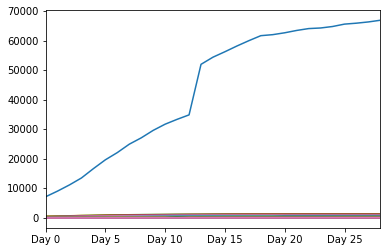

In [22]:
# trend of number of confirmed cases in each region
for i in range(0,df.shape[0]):
    df.iloc[i,:][1:].plot()

### Trend of number of confirmed cases in each region (Hubei excluded)

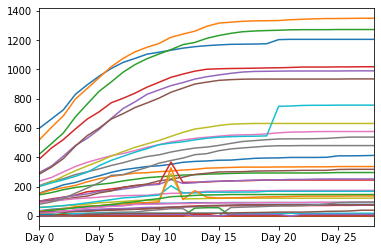

In [23]:
# trend of number of confirmed cases in each region (exclude Hubei)
for i in range(1,df.shape[0]):
    df.iloc[i,:][1:].plot()

In [24]:
# Defind functions that will be used later when analysis correlation between income and maximum infection percentage

# get the virus data of one city 
def get_virus_data_of_one_city(city):
    # find row index of the city in df
    row_index = find_string(df,city)[0]
    # get data of the desired city using row index
    city_data = df.iloc[row_index,:]
    # remove city name from city_data
    city_data = city_data[1:]
    return city_data

def get_population_data_of_one_city(city):
    # find row index of the city in df
    row_index = find_string(population_from_WHO_report,city)[0]
    # get population data of the desired city using row index
    city_population = population_from_WHO_report.iloc[row_index,1]
    return city_population

def calculate_infection_percentage_of_one_city(city):
    infected_number = get_virus_data_of_one_city(city)
    population = get_population_data_of_one_city(city)
    return infected_number/population

## Investigate correlation between income and maximum infection percentage

!!! Note: we need more virus data in March to make "maximum infection percentage" more accurate

### Calculate infection percentage and maximum infection percentage of each region


infection_percentage = confiremed cases / population


maximum infection percentage = max(infection_percentage)

#### Caclulate infection percentage

In [25]:
# Caclulate infection percentage
infection_percentage = df
row_index_of_regions_without_population = list()
for row in range(0,infection_percentage.shape[0]):
    city_name = infection_percentage.iloc[row,0]
    try:
        city_population = get_population_data_of_one_city(city_name)
        for column in range(1,infection_percentage.shape[1]):
            infection_percentage.iloc[row,column] = infection_percentage.iloc[row,column]/city_population
    except:
        row_index_of_regions_without_population.append(row)
for i in range (0,len(row_index_of_regions_without_population)):
    infection_percentage = infection_percentage.drop(row_index_of_regions_without_population[i])
infection_percentage = infection_percentage.reset_index(drop=True)        


#### Find the maximum infection percentage


In [26]:
# Find the maximum numerical number in a row
def find_row_max(df,row_index):
    num_cols = df.shape[1]
    max = 0.0
    for i in range(1,num_cols):
        value_in_ith_col = df.iloc[row_index,i]
        if (float(value_in_ith_col) > max):
            max = float(value_in_ith_col)
    return max

# Find the maximum numerical numbers in each row of the dataframe, save them into df['max']
def find_max(df):
    df['max'] = np.nan
    for i in range(0,df.shape[0]):
        df.loc[i,'max'] = find_row_max(df,i)

find_max(infection_percentage)
max_infection_percentage = infection_percentage[['Province/Region/City','max']]
max_infection_percentage.head()

,Province/Region/City,max
0,Hubei,0.001131
1,Zhejiang,0.000021
2,Guangdong,0.000012
3,Henan,0.000013
4,Hunan,0.000015


## Correlation between max infection percentage and income

### Include Hubei and try to find correlation

In [27]:
income = Income
income = income[['Region','2018']]
income.columns = ["Province/Region/City","income"]
income.shape

(31, 2)

In [28]:
analysis_df = income.merge(max_infection_percentage,how="inner")
analysis_df.head()

,Province/Region/City,income,max
0,Beijing,62361.22,0.000019
1,Tianjin,39506.15,0.000021
2,Hebei,23445.65,0.000004
3,Inner Mongolia,28375.65,0.000003
4,Liaoning,29701.45,0.000007


In [29]:
analysis_df.corr()
outcome, predictors = patsy.dmatrices('max ~ income', analysis_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    max   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                   0.03219
Date:                Tue, 10 Mar 2020   Prob (F-statistic):              0.859
Time:                        01:17:03   Log-Likelihood:                 205.22
No. Observations:                  29   AIC:                            -406.4
Df Residuals:                      27   BIC:                            -403.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.688e-05      0.000      0.627      0.5

#### Interpreting Outputs
p_value is too large, we fail to reject the hypothesis that maximum infection percentage of a region is uncorrelated to the people's income in that region. 

### Drop Hubei and try to find corrlation again
??????? TODO

As we've seen before, there appears to be no apparent corelation between maximun infection percentage of a region and the citizens' income. However, we must also consider the extreme outlier -- "Hubei" province. This province is where COVID-19 first broke out, and there have been special treatments and distinguished governmental interventions placed for this province. Therefore, to diminish such comfounds and come up with a more precise correlation relationship. We decide to drop the observation of Hubei province


In [30]:
# Drop the row that contains "Hubei"
row_index_of_Hubei = find_Hubei(analysis_df)[0]
analysis_df = analysis_df.drop(row_index_of_Hubei)
analysis_df = analysis_df.reset_index(drop = True)

# Do OLS again
outcome, predictors = patsy.dmatrices('max ~ income', analysis_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    max   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     7.041
Date:                Tue, 10 Mar 2020   Prob (F-statistic):             0.0134
Time:                        01:17:03   Log-Likelihood:                 298.55
No. Observations:                  28   AIC:                            -593.1
Df Residuals:                      26   BIC:                            -590.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.131e-06   2.98e-06      1.051      0.3

#### Interpret output
Let alpha = 0.05. Since p_value (0.013) is small, we can reject the hypothesis that income is not correlated with maximum infection percentage of a region. We conclude that maxmum infection percentage of an area is correlated with people's income in that area. 

(0, 3e-05)

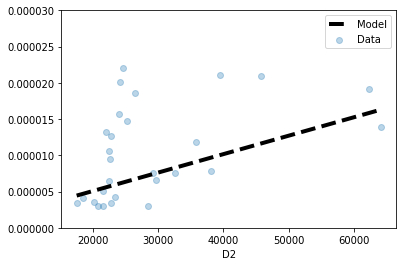

In [31]:
## Plot the model fit line

# Plot the orginal data (as before)
plt.scatter(analysis_df['income'], analysis_df['max'], alpha=0.3, label='Data');

# Generate and plot the model fit line
xs = np.arange(analysis_df['income'].min(), analysis_df['income'].max())
ys = 2.541e-10 * xs
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('D1')
plt.xlabel('D2')
plt.legend()
plt.ylim()
plt.ylim(top = 0.00003)
plt.ylim(bottom = 0)

#### Interpret output

After excluding Hubei, even though we concluded that income does correlate with maximum infection percentage in a region, we cannot establish the relatioship between them very well using the above linear model. 

#### Rename the "province/region/city" column to align with other dataframes and make it easier for later analyses

In [32]:
df = df.rename(columns = {'Province/Region/City':'Region'})

## Effect of Regional Gross Product(GRP) on COVID-19 outbreak

Now we use the ordinary least sqaures regression model(ols model) to figure out the correlation between GRP and COVID-19 breakout rate.

In [33]:
#single out the GRP in 2018 for each province 
GRP_2018 = GRP[GRP.columns[:2]]
#rename max_infection_percentage's region column for later merge
max_infection_percentage_1 = max_infection_percentage.rename(columns = {'Province/Region/City':'Region'})
#merge virus breakout rate data with GRP dataframe by province
GRP_virus = pd.merge(GRP_2018, max_infection_percentage_1, on = 'Region')
#rename the columns to be more meaningful and easier for further analyses
GRP_virus = GRP_virus.rename(columns = {'2018':'GRP'})
GRP_virus = GRP_virus.rename(columns = {'CAGR':'virus'})
GRP_virus.head()

,Region,GRP,max
0,Beijing,140211,0.000019
1,Tianjin,120711,0.000021
2,Hebei,47772,0.000004
3,Inner Mongolia,68302,0.000003
4,Liaoning,58008,0.000007


Now, we use an Ordinary Least Squares model to see the correlations between virus breakout rate and GRP in 2018 for each provinces.

In [34]:
#set up the outcome and what we use to predict using pasty
outcome1, predictors1 = patsy.dmatrices('max ~ GRP', GRP_virus)
# Now use statsmodels to intialize an OLS linear model
# This step initializes the model, and provides the data (but not actually compute the model)
mod_GRP = sm.OLS(outcome1, predictors1)
# fit the model
res_GRP = mod_GRP.fit()
# Check out the results
print(res_GRP.summary())

                            OLS Regression Results                            
Dep. Variable:                    max   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                  0.004336
Date:                Tue, 10 Mar 2020   Prob (F-statistic):              0.948
Time:                        01:17:04   Log-Likelihood:                 205.20
No. Observations:                  29   AIC:                            -406.4
Df Residuals:                      27   BIC:                            -403.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.315e-05   9.85e-05      0.438      0.6

Here, the correlation seems vague since we have a large p-value of 0.948. 

Now, we try to find the correlation again while exclude the case of "Hubei" province just as in the above section where we interpret relationship between income and virus breakout.

In [35]:
#drop observation in Hubei
GRP_virus = GRP_virus[GRP_virus.Region != 'Hubei']
#set up the outcome and what we use to predict using pasty
o1, p1 = patsy.dmatrices('max ~ GRP', GRP_virus)
# Now use statsmodels to intialize an OLS linear model
# This step initializes the model, and provides the data (but not actually compute the model)
mod_GRP_dropped = sm.OLS(o1, p1)
# fit the model
res_GRP_dropped = mod_GRP_dropped.fit()
# Check out the results
print(res_GRP_dropped.summary())

                            OLS Regression Results                            
Dep. Variable:                    max   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     5.884
Date:                Tue, 10 Mar 2020   Prob (F-statistic):             0.0225
Time:                        01:17:04   Log-Likelihood:                 298.05
No. Observations:                  28   AIC:                            -592.1
Df Residuals:                      26   BIC:                            -589.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    4.28e-06   2.79e-06      1.535      0.1

#### interpret results from OLS model

As we can see here, p-value here is 0.023, smaller than the general alpha value of 0.05. Therefore we can reject the hypothesis that GRP is not correlated with maximum infection percentage of a region. It's statistically significant to conclude that the maximum infection percentage of an area is correlated with GRP per capita in that area.

Now we visualize such relationship between GRP in 2018 to the breakout rate of COVID-19.

Use polyfit to fit a 1-degree linear model, predicting virus breakout rate from GRP.

(0, 3e-05)

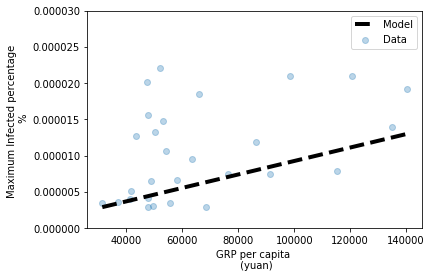

In [36]:
# Plot the orginal data (as before)
plt.scatter(GRP_virus['GRP'], GRP_virus['max'], alpha=0.3, label='Data');

# Generate and plot the model fit line
xs = np.arange(GRP_virus['GRP'].min(), GRP_virus['GRP'].max())
# use the coefficient from OLS summary above
ys = 9.272e-11 * xs
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('GRP per capita \n (yuan)')
plt.ylabel('Maximum Infected percentage \n %')
plt.legend()
plt.ylim()
plt.ylim(top = 0.00003)
plt.ylim(bottom = 0)

Next, we explore the correlation between the growth of GRP over the past 3 years in each province and the virus breakout rate

We calculate the Annual growth of GRP over 3 years according to the following formula:
        
        (GRP_new - GRP_old)/GRP_old
        

In [37]:
#add new column annual GRP growth for the past 3 years of each province applying above formula
GRP['growth'] = (GRP['2018'] - GRP['2016']) / GRP['2016']
#single out
GRP_growth = GRP[['Region','growth']]
#merge the virus breakout rate data with GRP  growth rate by province
GRP_growth_virus = pd.merge(GRP_growth, max_infection_percentage_1, on = 'Region')
GRP_growth_virus.head()

,Region,growth,max
0,Beijing,0.186238,0.000019
1,Tianjin,0.049177,0.000021
2,Hebei,0.109377,0.000004
3,Inner Mongolia,-0.052204,0.000003
4,Liaoning,0.142092,0.000007


Now, we use OLS model to see if GRP growth rate over the past 3 years is correlated with virus breakout data.

In [38]:
#set up the outcome and what we use to predict using pasty
outcome2, predictors2 = patsy.dmatrices('max ~ growth', GRP_growth_virus)
# Now use statsmodels to initialize an OLS linear model
# This step initializes the model, and provides the data (but not actually compute the model)
mod_GRP_growth = sm.OLS(outcome2, predictors2)
# fit the model
res_GRP_growth = mod_GRP_growth.fit()
# Check out the results
print(res_GRP_growth.summary())

                            OLS Regression Results                            
Dep. Variable:                    max   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.5363
Date:                Tue, 10 Mar 2020   Prob (F-statistic):              0.470
Time:                        01:17:04   Log-Likelihood:                 205.49
No. Observations:                  29   AIC:                            -407.0
Df Residuals:                      27   BIC:                            -404.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.537e-05   9.63e-05     -0.160      0.8

Again, we fail to reject the null hypothesis as p-value as large as 0.470. But that doesn't mean there's actually no correlation between GRP growth rate and virus breakout. We understand that Hubei is still a potentially extremely powerful outlier here. Therefore, we try to exclude Hubei again.

In [39]:
#drop observation in Hubei
GRP_growth_virus = GRP_growth_virus[GRP_growth_virus.Region != 'Hubei']
#set up the outcome and what we use to predict using pasty
o3, p3 = patsy.dmatrices('max ~ growth', GRP_growth_virus)
# Now use statsmodels to initialize an OLS linear model
# This step initializes the model, and provides the data (but not actually compute the model)
mod_growth_dropped = sm.OLS(o3, p3)
# fit the model
res_growth_dropped = mod_growth_dropped.fit()
# Check out the results
print(res_growth_dropped.summary())

                            OLS Regression Results                            
Dep. Variable:                    max   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.3480
Date:                Tue, 10 Mar 2020   Prob (F-statistic):              0.560
Time:                        01:17:04   Log-Likelihood:                 295.38
No. Observations:                  28   AIC:                            -586.8
Df Residuals:                      26   BIC:                            -584.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.839e-06   3.02e-06      2.924      0.0

#### interpret results from OLS model about GRP per capita growth rate and virus breakout rate
Unfortunately, the p-value of 0.560 is still rather large, which implies that the outlier of Hubei is not the factor that influenced our investigation. GRP per capita growth rate should trully be considered uncorrelated to the virus breakout rate. We shall have more discussion about possible reasons leading up to this result in the discussion section at the end.

## Effect of population density on COVID-19 Outbreak (as co-factor)

### Correlation between Population density and economic status

This part is to analyze the correlation between population density and economic status. We found the data for both population and area by each province. It needs to be calculated to population density first by dividing population by area.

We decide to use the population data from the most recent year available, which is 2018.
We also need to change the column name to "district" to correspond with the area dataset.

In [57]:
#extract the population data by only year 2018
population_2018 = population[population.columns[:2]]
population_2018.head()

,Region,2018
0,Beijing,2154
1,Tianjin,1560
2,Hebei,7556
3,Shanxi,3718
4,Inner Mongolia,2534


we will now merge the population and area dataset by the province name. We choose to "inner" merge them because if there is a province with either no population or area, we are unable to calculate the population density.
Then we could have calculate the population density by dividing population by area.
The unit for population density is number of people per square kilometer.

In [58]:
#merge area data and population of 2018 by region
popu_density = pd.merge(population_2018,area,on = 'Region')

#calculate the population density
popu_density['Area'] = pd.to_numeric(popu_density['Area'])
popu_density['2018'] = pd.to_numeric(popu_density['2018'])
popu_density['population density'] = popu_density['2018']/popu_density['Area']
popu_density = popu_density.drop(columns = 'Area')
popu_density = popu_density.drop(columns = '2018')
popu_density.head()

,Region,population density
0,Beijing,0.131293
1,Tianjin,0.130905
2,Hebei,0.040075
3,Shanxi,0.023727
4,Shanxi,0.018082


we will now merge the data for population density and economic status by province. Since we use the population data in 2018 for calculating the population density, we will also use GRP in 2018 to find the correlation between population density and economic status.

In [42]:
#merge population density data with GRP by region
co_pd_es = pd.merge(popu_density,GRP, on = 'Region')
co_pd_es = co_pd_es[co_pd_es.columns[:3]]
#rename the 2018 GRP column
co_pd_es = co_pd_es.rename(columns = {'2018':'GRP'})
co_pd_es.head()

,Region,population density,GRP
0,Beijing,0.131293,140211
1,Tianjin,0.130905,120711
2,Hebei,0.040075,47772
3,Shanxi,0.023727,45328
4,Shanxi,0.018082,45328


Now, we look into the correlation between population density and GRP to see if they're actually correlated. We use the Pasty statsmodel to quantify our results.

In [43]:
co_pd_es = co_pd_es.rename(columns = {'population density':'density'})
#we want to see how well does population density and GRP correlate using pasty
outcome, predictors = patsy.dmatrices('density ~ GRP', co_pd_es)
# Now use statsmodels to intialize an OLS linear model
#  This step initializes the model, and provides the data (but not actually compute the model)
mod = sm.OLS(outcome, predictors)
# fit the model
res = mod.fit()
# Check out the results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                density   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     50.26
Date:                Tue, 10 Mar 2020   Prob (F-statistic):           1.03e-07
Time:                        01:17:04   Log-Likelihood:                 59.227
No. Observations:                  30   AIC:                            -114.5
Df Residuals:                      28   BIC:                            -111.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0561      0.015     -3.653      0.0

As we can see from the coefficient and R-squared value above, there's a positive relationship between population density and region gross product. 

Now we can visualize the correlation between population density and GRP . we will make a scatter plot of GRP vs. population density and draw the linear regression line to show the relationship.

In [55]:
#finding the coefficient for the fit line using polyfit
a1 = np.polyfit(co_pd_es['density'],co_pd_es['GRP'],deg = 1)[0]
b1 = np.polyfit(co_pd_es['density'],co_pd_es['GRP'],deg = 1)[1]
a1,b1

(418533.9004044728, 46606.9870364815)

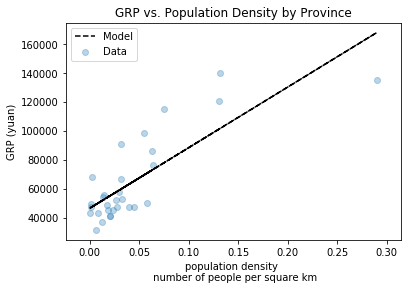

In [54]:
#plot the original data
plt.scatter(co_pd_es['density'],co_pd_es['GRP'],alpha =0.3, label = 'Data')

#Generate and plot the model fit line
pred_GRP = co_pd_es['density']*a1+b1
plt.plot(co_pd_es['density'],pred_GRP,'--k',label = 'Model')

plt.title('GRP vs. Population Density by Province')
plt.xlabel("population density \n number of people per square km" )
plt.ylabel("GRP (yuan)")
plt.legend()

From this plot, it is clear that there is a positive relationship between population density and GRP. The regions with higher population density tend to have higher GRP. Thus, population density might also serve as a factor that confounds with the economic status. 

With better GRP, the province are expected to have a slower breakout rate due to the the better infrastructures like hospitals or clinics to support the citizens against the cirus. However, the breakout rates are actually tend to be higher with province with higher GRP. Population density might be the most important cofounding factor for this controversy. 

Now, we will look at the correlation between population density and the virus breakout rate to see whether they are in fact correlated.

## correlation between population density and maximum infection percentage

In [46]:
#merge population density data with virus breakout rate by region
PD_virus = pd.merge(popu_density, max_infection_percentage_1, on = 'Region')
#rename the population density column
PD_virus = PD_virus.rename(columns = {'population density':'PD'})
PD_virus.head()


,Region,PD,max
0,Beijing,0.131293,0.000019
1,Tianjin,0.130905,0.000021
2,Hebei,0.040075,0.000004
3,Inner Mongolia,0.002212,0.000003
4,Liaoning,0.029377,0.000007


We will use an Ordinary Least Squares model to find the correlation between population density and the virus breakout rate in 2018 for each provinces.

In [47]:
#set up the outcome and what we use to predict using pasty
npvoutcome1, npvpredictors1 = patsy.dmatrices('max~ PD',PD_virus)
#now use statsmodels to initialize an OLS linear model
#this step initializes the model, and provides the data without actually computes the model
mod_PD = sm.OLS(npvoutcome1,npvpredictors1)
#fit the model
res_PD = mod_PD.fit()
#check out the results
print(res_PD.summary())

                            OLS Regression Results                            
Dep. Variable:                    max   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                   0.03233
Date:                Tue, 10 Mar 2020   Prob (F-statistic):              0.859
Time:                        01:17:05   Log-Likelihood:                 190.13
No. Observations:                  27   AIC:                            -376.3
Df Residuals:                      25   BIC:                            -373.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.774e-05    5.4e-05      1.068      0.2

The correlation seems vague because we have a large p-value of 0.859.

Now we try to find the correlation again while exclude the case of "Hubei" province just as in the above section.

In [48]:
#drop observation in Hubei
PD_virus = PD_virus[PD_virus.Region != 'Hubei']
#set up the outcome and what we use to predict using pasty
npvo1, npvp1 = patsy.dmatrices('max ~ PD', PD_virus)
# Now use statsmodels to intialize an OLS linear model
# This step initializes the model, and provides the data (but not actually compute the model)
mod_PD_dropped = sm.OLS(npvo1, npvp1)
# fit the model
res_PD_dropped = mod_PD_dropped.fit()
# Check out the results
print(res_PD_dropped.summary())

                            OLS Regression Results                            
Dep. Variable:                    max   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     5.373
Date:                Tue, 10 Mar 2020   Prob (F-statistic):             0.0293
Time:                        01:17:05   Log-Likelihood:                 276.57
No. Observations:                  26   AIC:                            -549.1
Df Residuals:                      24   BIC:                            -546.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.019e-06   1.51e-06      5.308      0.0

#### interpret results from OLS model

As we can see here, p-value here is 0.029, smaller than the general alpha value of 0.05. Therefore we can reject the hypothesis that population density is not correlated with maximum infection percentage of a region. It's statistically significant to conclude that the maximum infection percentage of an area is correlated with population density per capita in that area. In such case, we confirm that the population density serve as a cofactor that contributes to the correlation between GRP and maximum infection percentage.

Now we visualize such relationship between population density in 2018 to the breakout rate of COVID-19.

Use polyfit to fit a 1-degree linear model, predicting virus breakout rate from population density.


(0, 3e-05)

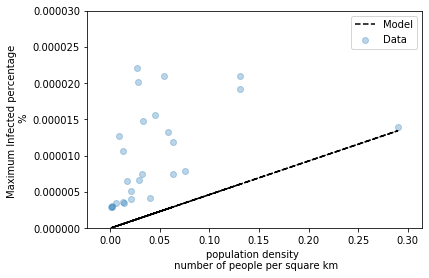

In [49]:
# Plot the orginal data (as before)
plt.scatter(PD_virus['PD'], PD_virus['max'], alpha=0.3, label='Data');

# Generate and plot the model fit line
# use the coefficient from OLS summary above
PDmodel = PD_virus['PD']*4.635e-5 
plt.plot(PD_virus['PD'],PDmodel,'--k',label = 'Model')

plt.xlabel('population density \n number of people per square km')
plt.ylabel('Maximum Infected percentage \n %')
plt.legend()
plt.ylim()
plt.ylim(top = 0.00003)
plt.ylim(bottom = 0)

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*